### APPLICA DBSCAN

In [54]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform

# Add these imports at the top
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import DBSCAN

#in titanic fa con scipy
    #from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

#vedere se serve
#evaluation
from sklearn.metrics import silhouette_score

#vedere se serve
#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform

### features

In [55]:

df = pd.read_csv("pp_train.csv")
features = df[['startYear', 'fill_runtimeMinutes', 'awardWins', 'numVotes', 'totalImages','totalVideos', 'totalCredits', 'criticReviewsTotal', 
               'awardNominationsExcludeWins','numRegions', 'userReviewsTotal']]

df_num = features.values

#presuppongo di voler fare poi i controlli cluster in abse a titletype
y = np.array(df['titleType']) 
#a way to define x and y; they are the numpy arrays of the dataset

y_map = {
    0: 'tvEpisode',
    1: 'videoGame',
    2: 'movie',
    3: 'tvSeries',
    4: 'video',
    5: 'tvMiniSeries',
    6: 'short',
    7: 'tvMovie',
    8: 'tvSpecial',
    9: 'tvShort'
}
y_mapped = pd.DataFrame(y).iloc[:,0].map(y_map)
#y is our target label; mapped into strings (y_map)

## Normalizzazioni

In [56]:
X = df_num.copy()
X = np.log1p(X)

# z-score, fit and then transform
scaler = StandardScaler()   #inizialize the standard scaler
scaler.fit(X) #fit the scaler on the data; x è la numpy matrix of the dataset
X_z_scal = scaler.transform(X) #transform to have the scaled version


# min-max, fit and trasform directly
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X) #fit e scaler in una riga sola

#SCELTA NORMALIZZAZIONE
X_scal = X_z_scal

In [57]:


#solo con 2 cluster
    #dbscan = DBSCAN(eps=2, min_samples=22, metric="euclidean")
    #dbscan = DBSCAN(eps=1.98, min_samples=11, metric="euclidean")
    #dbscan = DBSCAN(eps=2, min_samples=12, metric="euclidean")

#con 3 cluster
#dbscan = DBSCAN(eps=1.55, min_samples=22, metric="euclidean")
            # in teoria no #dbscan = DBSCAN(eps=2, min_samples=11, metric="euclidean") 

#dbscan = DBSCAN(eps=1.565, min_samples=17, metric="euclidean") 
dbscan = DBSCAN(eps=1.564, min_samples=11, metric="euclidean") #-> 3 cluster, UN PO' MEGLIO COME VALORI


dbscan.fit(X_scal)

DBSCAN(eps=1.564, min_samples=11)

In [58]:
dbscan.labels_ #get labels (classification of the diff clusters (-1 è il noise))
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2], dtype=int64),
 array([ 1753, 13198,   733,   747], dtype=int64))

### Silhouette

In [59]:
print('Silhouette', silhouette_score(X_scal, dbscan.labels_)) #con noise cluster

print('Silhouette', silhouette_score(X_scal[dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1]))  #senza noise

        # misura silh su DBSCAN LABELS la conta anche rispetto al noise cluster (-1) 
        # -> se non lo consid abbiamo valore + alto (i noise points sono lontani, lunghe distanze influenzano la silh) 
            # -> quando la misuro scartiamo anche noise così misuriamo risultato solo sui cluster

Silhouette 0.13922006196653053
Silhouette 0.17597145135054537


In [60]:
""" 
sns.scatterplot(data=df,x="criticReviewsTotal", y="numVotes", 
                hue=dbscan.labels_, style=dbscan.labels_, palette="bright")
plt.show()
"""

' \nsns.scatterplot(data=df,x="criticReviewsTotal", y="numVotes", \n                hue=dbscan.labels_, style=dbscan.labels_, palette="bright")\nplt.show()\n'

### Kth neighbor distance (misuro distanzde dal kth nearest n.)

In [61]:
dist = pdist(X_scal, 'euclidean') 
dist = squareform(dist)

    #risultato -> array compresso con distanze per ogni coppia di punti nel dataset.

#### PLOT DISTANZE -> misuro distanze dal kth, xth, yth nearest n.
##### utile se data is larger, provare con diversi valori di k (pox si rivelino clusters)

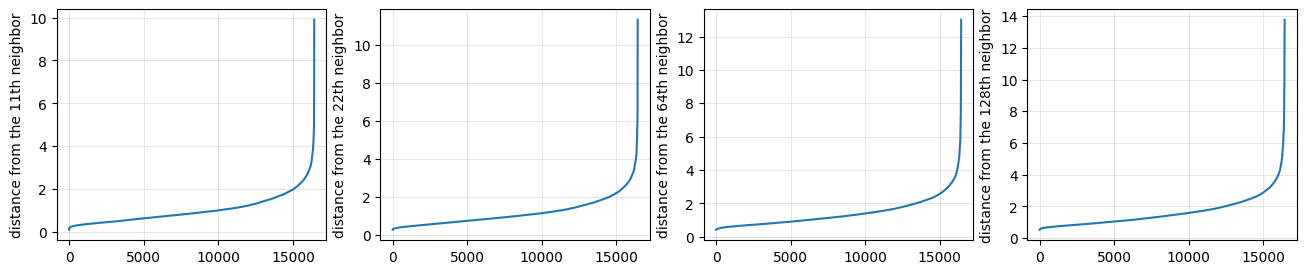

In [62]:

#strandardscaler ks = [11, 16, 22, 64]
from kneed import KneeLocator


ks = [11, 22, 64, 128]


fig = plt.figure(figsize=(16, 3)) # dimensions of the overall plot
fig_dims = (1, len(ks))

for i in range(len(ks)):
    k = ks[i]
    kth_distances = []

    for d in dist:  # d is a vector containing distances between the ith record and all the others
        index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
        kth_distances.append(d[index_kth_distance])  # store the distance in a list

    plt.subplot2grid(fig_dims, (0, i))
    plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
    plt.ylabel('distance from the {}th neighbor'.format(k))
    plt.grid(True, alpha=0.3)
             
#plt.tight_layout()
#fig, axes = plt.subplots(2, 3, figsize=(15, 10))
plt.show()


 ### codice per trovare valore di eps automaticamente

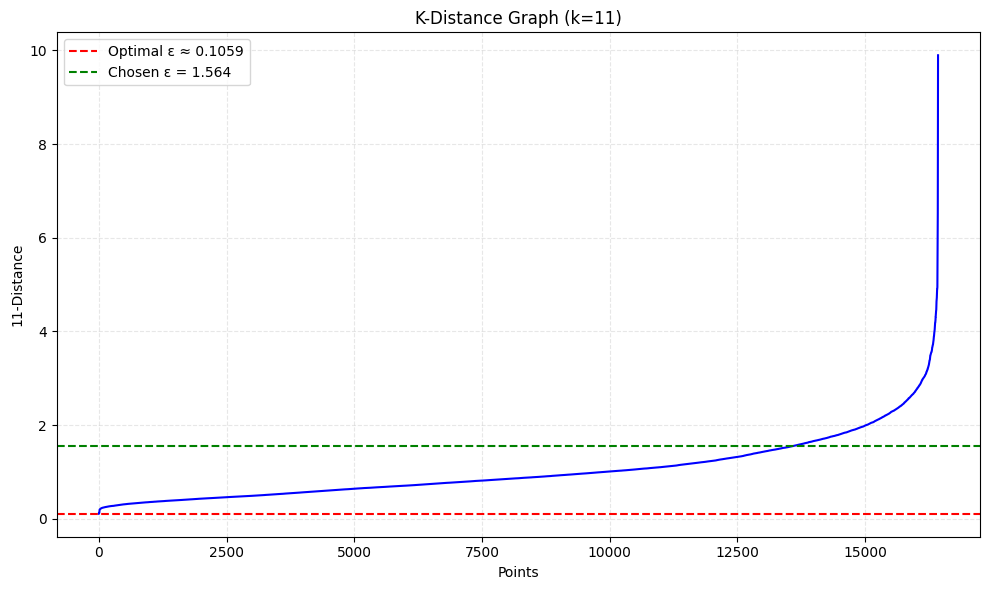

Suggested Optimal Epsilon: 0.1059


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from kneed import KneeLocator

def calculate_k_distance_graph(X, k):
    """
    Calculate the k-distance graph for a pre-scaled dataset
    
    Parameters:
    -----------
    X : numpy array
        Pre-scaled input dataset
    k : int
        Number of nearest neighbors to consider
    
    Returns:
    --------
    k_distances : numpy array
        Sorted k-distances for each point
    """
    # Calculate pairwise distances
    distances = pdist(X)
    dist_matrix = squareform(distances)
    
    # Sort distances for each point and get k-th distances
    k_distances = np.sort(dist_matrix, axis=1)[:, k]
    
    return k_distances

def plot_k_distance_graph(X, k):
    """
    Plot the k-distance graph to help select epsilon for DBSCAN
    using Kneedle algorithm
    
    Parameters:
    -----------
    X : numpy array
        Pre-scaled input dataset
    k : int
        Number of nearest neighbors to consider
    
    Returns:
    --------
    optimal_epsilon : float
        Suggested optimal epsilon value
    """
    # Calculate k-distances
    k_distances = calculate_k_distance_graph(X, k)
    
    # Sort k-distances in ascending order
    sorted_k_distances = np.sort(k_distances)
    
    # Use Kneedle algorithm to find the knee point
    try:
        kneedle = KneeLocator(
            range(len(k_distances)), 
            sorted_k_distances, 
            curve="concave", 
            direction="increasing"
        )
        
        # Get the optimal epsilon (knee point)
        optimal_epsilon = sorted_k_distances[kneedle.knee] if kneedle.knee is not None else None
        
        # Plot k-distance graph
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(sorted_k_distances)), sorted_k_distances, 'b-')
        plt.title(f'K-Distance Graph (k={k})')
        plt.xlabel('Points')
        plt.ylabel(f'{k}-Distance')
        
        # Plot red line for optimal epsilon if found
        if optimal_epsilon is not None:
            plt.axhline(y=optimal_epsilon, color='r', linestyle='--', 
                        label=f'Optimal ε ≈ {optimal_epsilon:.4f}')
            plt.legend()
        
        plt.axhline(y=1.564, color='g', linestyle='--', 
                    label='Chosen ε = 1.564')
        
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return optimal_epsilon
    
    except Exception as e:
        print(f"Error finding optimal epsilon: {e}")
        return None

def main(X):
    """
    Main function to find optimal epsilon for DBSCAN
    
    Parameters:
    -----------
    X : numpy array
        Pre-scaled input dataset
    """
    # Plot k-distance graph and find optimal epsilon
    optimal_epsilon = plot_k_distance_graph(X, k=11)
    
    if optimal_epsilon is not None:
        print(f"Suggested Optimal Epsilon: {optimal_epsilon:.4f}")
    else:
        print("Could not determine optimal epsilon")
    
    return optimal_epsilon

# Example usage
if __name__ == '__main__':
    X = X_scal
    
    # Call main function with your pre-scaled data
    main(X)

### PCA PER VISUALIZZARLO

C:\Users\noemi\AppData\Local\Temp\ipykernel_17984\3618167256.py:36: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles = [plt.scatter([], [], c=c, alpha=0.5, label=f'Cluster {l}')


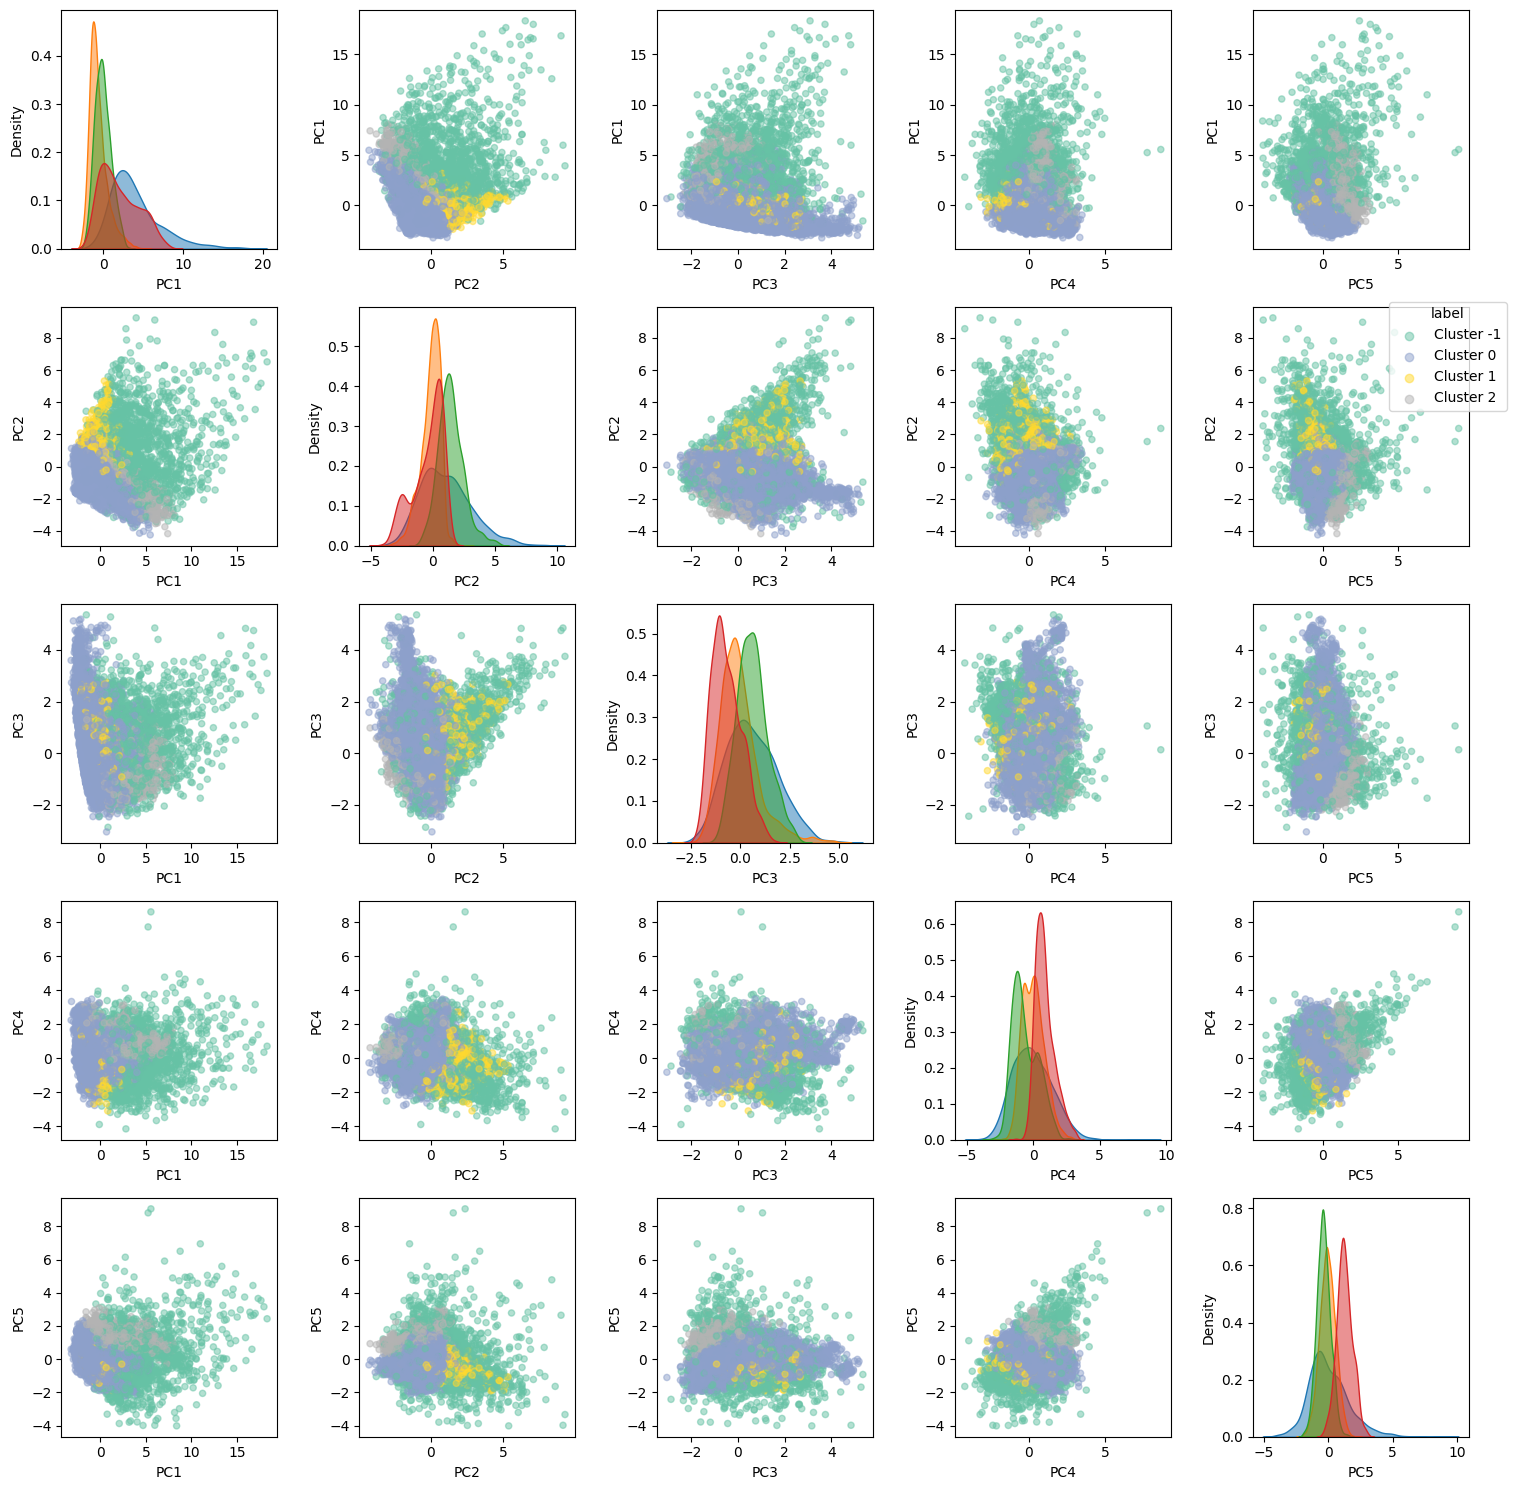


Explained variance ratios:
PC1: 0.430
PC2: 0.123
PC3: 0.105
PC4: 0.083
PC5: 0.062


In [64]:
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Apply PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scal)

# Create a figure with a grid of subplots
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

# Create labels for each axis
pc_labels = [f'PC{i+1}' for i in range(5)]

# Plot each combination
for i in range(5):
    for j in range(5):
        if i != j:
            # Scatter plot
            axes[i, j].scatter(X_pca[:, j], X_pca[:, i], 
                             c=dbscan.labels_, cmap='Set2',
                             alpha=0.5, s=20)
            axes[i, j].set_xlabel(pc_labels[j])
            axes[i, j].set_ylabel(pc_labels[i])
        else:
            # Density plot
            for label in np.unique(dbscan.labels_):
                sns.kdeplot(data=X_pca[dbscan.labels_ == label, i],
                          ax=axes[i, i], fill=True,
                          alpha=0.5)
            axes[i, i].set_xlabel(pc_labels[i])
            axes[i, i].set_ylabel('Density')

# Add legend
handles = [plt.scatter([], [], c=c, alpha=0.5, label=f'Cluster {l}')
           for l, c in zip(np.unique(dbscan.labels_),
                          plt.cm.Set2(np.linspace(0, 1, len(np.unique(dbscan.labels_)))))]
fig.legend(handles=handles, title='label', bbox_to_anchor=(1.02, 0.8))

# Adjust layout
plt.tight_layout()
plt.show()

# Print explained variance ratios
print("\nExplained variance ratios:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {ratio:.3f}")

### codice per vedere sia plot che statistiche decsrittive dei cluster


Statistiche dei Cluster:
--------------------------------------------------

Cluster -1:
Numero di punti: 1753
Percentuale del dataset: 10.67%
Deviazione standard media delle features: 1.504
Range medio delle features: 8.621

Cluster 0:
Numero di punti: 13198
Percentuale del dataset: 80.32%
Deviazione standard media delle features: 0.635
Range medio delle features: 4.245

Cluster 1:
Numero di punti: 733
Percentuale del dataset: 4.46%
Deviazione standard media delle features: 0.660
Range medio delle features: 3.300

Cluster 2:
Numero di punti: 747
Percentuale del dataset: 4.55%
Deviazione standard media delle features: 0.886
Range medio delle features: 4.022


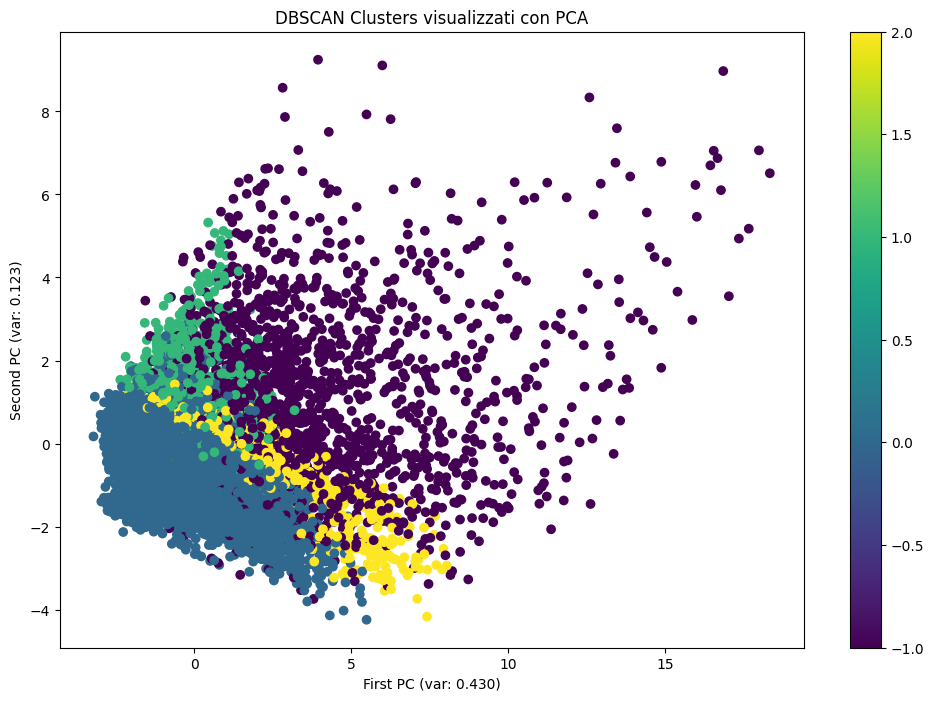

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# Visualizzazione con PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scal)

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan.labels_, cmap='viridis')
plt.colorbar(scatter)
plt.title('DBSCAN Clusters visualizzati con PCA')
plt.xlabel(f'First PC (var: {pca.explained_variance_ratio_[0]:.3f})')
plt.ylabel(f'Second PC (var: {pca.explained_variance_ratio_[1]:.3f})')

# Statistiche per cluster
def cluster_statistics(X, labels):
    stats = {}
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        mask = labels == label
        cluster_points = X[mask]
        
        stats[f'Cluster {label}'] = {
            'Size': len(cluster_points),
            'Percentage': f"{(len(cluster_points) / len(X) * 100):.2f}%",
            'Mean': np.mean(cluster_points, axis=0),
            'Std': np.std(cluster_points, axis=0),
            'Min': np.min(cluster_points, axis=0),
            'Max': np.max(cluster_points, axis=0)
        }
    
    return stats

# Calcola e mostra le statistiche
stats = cluster_statistics(X_scal, dbscan.labels_)

print("\nStatistiche dei Cluster:")
print("-" * 50)
for cluster, stat in stats.items():
    print(f"\n{cluster}:")
    print(f"Numero di punti: {stat['Size']}")
    print(f"Percentuale del dataset: {stat['Percentage']}")
    print(f"Deviazione standard media delle features: {np.mean(stat['Std']):.3f}")
    print(f"Range medio delle features: {np.mean(stat['Max'] - stat['Min']):.3f}")